# CS 6320 Project 4: Projection Matrix and Fundamental Matrix Estimation with RANSAC

You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses and explanations. Explain what you do and analyze your results. This assignment has a total of 100 points distributed for three sub-parts listed below.

(1) Projection Matrix  
(2) Fundamental Matrix Estimation  
(3) Fundamental Matrix with RANSAC  

# Brief
    Due Data: Listed in Canvas
    Hand-in : Through Canvas
    Required files: <your_uid>.zip.(Please begin with 'u' for your uid)


## Setup

   0. Unzip proj4_6320.zip and go to proj4_6320 directory.
      - You can run `unzip proj4_6320.zip && cd proj4_6320` in your terminal.
   1. Install [Miniconda](https://docs.conda.io/en/latest/miniconda.html). It doesn’t matter whether you use Python 2 or 3 because we will create our own environment that uses 3 anyways.
   2. Create a conda environment using the appropriate command. On Windows, open the installed “Conda prompt” to run the command. On MacOS and Linux, you can just use a terminal window to run the command, Modify the command based on your OS (linux, mac, or win): `conda env create -f proj4_env_<OS>.yml`.
    - NOTE that proj4_env_<OS>.yml is inside the project folder.
   3. This should create an environment named ‘proj4’. Activate it using the Windows command, activate proj4 or the MacOS / Linux command, conda activate proj4
   4. Run the notebook using `jupyter notebook` under *proj4_6320* directory.
   6. Generate the zip folder for the code portion of your submission once you’ve finished the project using 
    
        `python zip_submission.py --uid <your_uid>` 


## Writeup
For this project, this notebook itself is the report. You must answer each of the questions (associated with each part) in a separate cell.

You must run all your cells before you hand in it. You code, results, visualization, and discussion will be used for the grading. You will be deducted points if the results are not shown in this notebook. Do not change the order of the cells. You can add cells in need. You can copy a cell and run it seperately if you need to run a cell multiple times and thus every result is displayed in the cell.


## Rubric
    +33 pts: Part_1
    +34 pts: Part_2
    +33 pts: Part_3

    -5 pts: Lose 5 points for every time you do not follow the instructions for the hand-in format.
    
Submission Format

This is very important as you will lose 5 points for every time you do not follow the instructions. You will attach only one items in your submission on Canvas:

1. <your_uid>.zip containing:
    - proj4_code/ - directory containing all your code for this assignment
    - data/       - directory containing all the input images
    - results/    - directory containing all the output images

Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that’s not in there by default will probably cause your code to break during grading. Do not use absolute paths in your code or your code will break. Use relative paths. Failure to follow any of these instructions will lead to point deductions. Create the zip file using python zip_submission.py --uid <your_uid> (it will zip up the appropriate directories/files for you!)

## Setup

In [1]:
%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *

# Part 1 Projection Matrix Estimation

## Part 1.1 Implement Camera Projection

In this initial part, in `projection_matrix.py` you will implement camera projection in the `projection(P, points_3d)` from homogenous world coordinates $X_i = [X_i, Y_i, Z_i, 1]$ to non-homogenous pixel coordinates $x_i, y_i$.

It will be helpful to recall the equations to convert to pixel coordinates

\begin{align}
x_i = \frac{p_{11}X_i+p_{12}Y_i + p_{13}Z_i + p_{14}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}} \quad y_i = \frac{p_{21}X_i+p_{22}Y_i + p_{23}Z_i + p_{24}}{p_{31}X_i+p_{32}Y_i + p_{33}Z_i + p_{34}}
\end{align}

In [2]:
import projection_matrix
# np.set_printoptions(suppress=True) # Suppresses printing in scientific notation

from unit_tests.part1_unit_test import (
    verify, 
    test_projection, 
    test_objective_func,
    test_decompose_camera_matrix,
    test_calculate_camera_center,
    test_estimate_camera_matrix)

In [3]:
print('Test for camera projection:', verify(test_projection))

Test for camera projection: "Correct"


## Part 1.2: Objective Function 

In this part, in `projection_matrix.py` you will implement the objective function `objective_function(x, **kwargs)` that will be passed to `scipy.optimize.least_squares` for minimization with the Levenberg-Marquardt algorithm. The input to this function is a [vectorized](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) camera matrix, the output is the term that gets squared in the objective function and should also be vectorized. Scipy takes care of the squaring + summation part.

\begin{align}
\sum_{i=1}^N ( \color{purple}{\hat{\mathbf{P}}\mathbf{X}_w^i-\mathbf{x}^i })^2
\end{align}

In [4]:
print('Test for objective_function:', verify(test_objective_func))

Test for objective_function: "Correct"


## Part 1.3: Estimating the Projection Matrix Given Point Correspondences

Initially you will run the optimization to estimate $\mathbf{P}$ using an initial guess that we provide.

### Good initial estimate for $\mathbf{P}$.

Optimizing the reprojection loss using Levenberg-Marquardt requires a good initial estimate for $\mathbf{P}$. This can be done by having good initial estimates for $\mathbf{K}$ and $\mathbf{R}^T$ and $\mathbf{t}$ which you can multiply to then generate your estimated $\mathbf{K}$.

In [5]:
initial_guess_K = np.array([[ 500,   0, 535],
                            [   0, 500, 390],
                            [   0,   0,  -1]])

initial_guess_R_T = np.array([[ 0.5,   -1,  0],
                            [   0,    0, -1],
                            [   1,  0.5,  0]])

initial_guess_I_t = np.array([[   1,    0, 0, 300],
                              [   0,    1, 0, 300],
                              [   0,    0, 1,  30]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [6]:
# set the paths and load the data
pts2d_path = '../data/pts2d-pic_b.txt'
pts3d_path = '../data/pts3d.txt'
img_path   = '../data/pic_b.jpg'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(img_path)

### Estimate the projection matrix given corresponding 2D & 3D points

In [7]:
print('Test for estimate_camera_matrix:', verify(test_estimate_camera_matrix))

`ftol` termination condition is satisfied.
Function evaluations 1055, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
status True `ftol` termination condition is satisfied.
Time since optimization start 0.14084911346435547
Test for estimate_camera_matrix: "Correct"


`ftol` termination condition is satisfied.
Function evaluations 1055, initial cost 2.9929e+07, final cost 6.8831e+00, first-order optimality 2.76e+05.
status True `ftol` termination condition is satisfied.
Time since optimization start 0.13871192932128906
The projection matrix is
 [[-2.04554494e+00  1.18126347e+00  4.05588700e-01  2.44822772e+02]
 [-4.55828572e-01 -3.04148029e-01  2.14988423e+00  1.66188175e+02]
 [-2.24222858e-03 -1.09957049e-03  5.71552982e-04  1.00000000e+00]]
The total residual is 14.711462


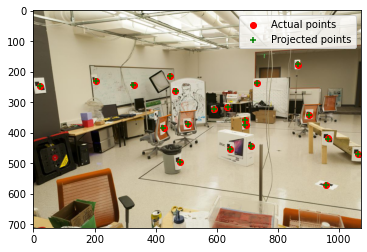

In [8]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, '../data/pic_b.jpg')


## Part 1.4: Decomposing the projection matrix

In this part in `projection_matrix.py` you will implement `decompose_camera_matrix(P)` that takes as input the camera matrix $\mathbf{P}$ and outputs the intrinsic $\mathbf{K}$ and rotation matrix ${}_c\mathbf{R}_w$, 

In [9]:
print('Test for decomposing projection matrix:', verify(test_decompose_camera_matrix))
K, R = projection_matrix.decompose_camera_matrix(P)

Test for decomposing projection matrix: "Correct"


## Part 1.5: Calculating Camera Center

In this part in `projection_matrix.py` you will implement `calculate_camera_center(P, K, R)` that takes as input the 
projection $\mathbf{P}$, intrinsic $\mathbf{K}$ and extrinsic ${}_c\mathbf{R}_w$ matrix and outputs the camera position in world coordinates.

In [10]:
print('Test for calculating camera center:', verify(test_calculate_camera_center))
center = projection_matrix.calculate_camera_center(P, K, R)

Test for calculating camera center: "Correct"


We can now visualize the camera center and the camera coordinate system as well as the  the world coordinate system.

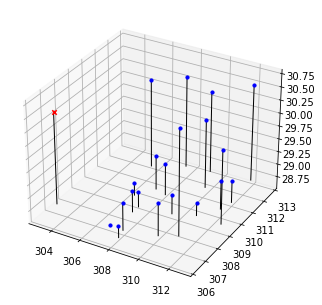

In [11]:
plot3dview(points_3d, center)

## Part 1.6: Taking Your Own Images and Estimating the Projection Matrix + Camera Pose

In this part you will take two images of your fiducial object. If you want to also reuse these images for Part II, keep in mind how to take good images for estimating the Fundamental Matrix.

In [12]:
image1_path = '../data/book1.jpg'
image2_path = '../data/book2.jpg'

img1 = load_image(image1_path)
img2 = load_image(image2_path)

Measure your fiducial object and define a coordinate system. Fill out the `points_3d` variable with the 3D point locations of the points you'll use for correspondences.

Note: the 3D coordinate is 17 inch width by 24 inch in height, and 3 inches in depth. The image pixel coordinates in 3D are 750 in width, 1000 in height, and 100 in depth. 

In [13]:
points_3d = np.array([[143, 948, 58], [143, 479, 58], [507, 479, 58], [507, 948, 58], 
                      [88, 375, 19], [88, 177, 19], [640, 177, 19], [640, 177, 19],
                      [352, 583, 58]])

Now for each image, find the 2D pixel locations of your 3D points. Hovering over the image gives you the `x,y` coordinates of your cursor on the image. You can use the lower left side controls to zoom into the image for more precise measurements. Fill out `points2d_img1` with these coordinate values.

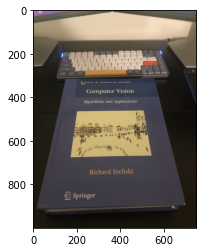

In [14]:
# plotting image 1
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img1)

In [15]:
points2d_img1 = np.array([[24,  893], [157, 323], [553, 323], [700, 903], 
                          [111, 319], [139, 199], [590, 181], [622, 305], 
                          [378, 420]])

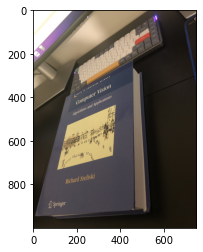

In [16]:
# plotting image 2
fig = plt.figure(); ax = fig.add_subplot(111); ax.imshow(img2)

In [17]:
points2d_img2 = np.array([[15, 949], [157, 406], [456, 241], [470, 922], 
                          [171, 383], [190, 273], [571, 25], [590, 158],
                          [281, 434]])

Our objective function will need to read the measurements you just saved from disk. We need to save this data now.

In [18]:
np.savetxt('../results/pts3d_fiducial.npy', points_3d)
np.savetxt('../results/pts2d_image1.npy', points2d_img1)
np.savetxt('../results/pts2d_image2.npy', points2d_img2)

## Part 1.7: Making your own $\mathbf{K}$,  $\mathbf{R}^T$ and $[\mathbf{I}|\mathbf{t}]$ estimates.

In [19]:
initial_guess_K = np.array([[   1,   0,  0],
                            [   0,   1,  0],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 1,   0,  0],
                              [ 0,   1,  0],
                              [ 0,   0,  1]])

initial_guess_I_t = np.array([[   1,    0, 0, 320],
                              [   0,    1, 0, -800],
                              [   0,    0, 1, 500]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [20]:
# set the paths and load the data
pts2d_path = '../results/pts2d_image1.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system. RGB colors correspond with XYZ (first, second and third coordinate). Be mindful of whether you should be passing `R` or `R.T` in for your rotation matrix.

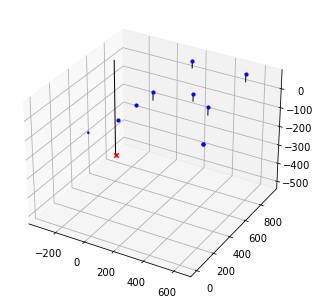

In [21]:
plot3dview_with_coordinates(points_3d, -initial_guess_I_t[:,3], initial_guess_R_T.T)

View the optimization results given your initial guess. If your initial guess is poor the optimizition **will not** work. You will need to make initial estimates for both the images you took.

`ftol` termination condition is satisfied.
Function evaluations 1035, initial cost 1.9447e+06, final cost 4.4232e+03, first-order optimality 2.74e+01.
status True `ftol` termination condition is satisfied.
Time since optimization start 0.07544112205505371
The projection matrix is
 [[ 7.85102061e-01 -2.03270586e-01 -2.58570140e-02  9.18068665e+01]
 [ 6.22895046e-02  3.01934679e-01 -1.56739433e+00  1.55761914e+02]
 [ 5.63240486e-05 -6.16049543e-04 -3.64469596e-04  1.00000000e+00]]
The total residual is 179.308907


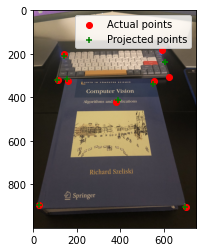

In [22]:
P1 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
print('The projection matrix is\n', P1)

[projected_2d_pts, residual] = evaluate_points(P1, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

Visualize your estimate for the camera pose relative to the world coordinate system.

In [23]:
# set the pats and load the data
pts2d_path = '../results/pts2d_image2.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([500., 375.])

In [24]:
initial_guess_K = np.array([[   1,   0,  0],
                            [   0,   1,  0],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 1,   0, 0],
                              [ 0,   60, 0],
                              [ 0,   0, 1]])

initial_guess_I_t = np.array([[1, 0, 0, 900],
                              [0, 1, 0, 800],
                              [0, 0, 1, 300]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

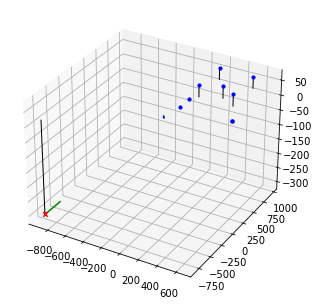

In [25]:
# change this plot to show the world coordinate system better
plot3dview_with_coordinates(points_3d, -initial_guess_I_t[:,3], initial_guess_R_T.T) 

`ftol` termination condition is satisfied.
Function evaluations 377, initial cost 1.9187e+07, final cost 5.1998e+03, first-order optimality 1.86e+02.
status True `ftol` termination condition is satisfied.
Time since optimization start 0.030745983123779297
The projection matrix is
 [[ 4.02887451e-01 -1.75389175e-01 -1.31421215e+00  1.90418613e+02]
 [-3.22281523e-01  3.56325543e-01 -1.95782974e+00  2.38625791e+02]
 [-3.18279644e-04 -3.97858254e-04 -2.36365164e-03  1.00000000e+00]]
The total residual is 215.460992


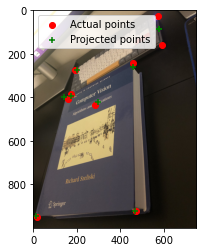

In [26]:
P2 = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)
#M = sc.calculate_projection_matrix(points_2d, points_3d)
print('The projection matrix is\n', P2)

[projected_2d_pts, residual] = evaluate_points(P2, points_2d, points_3d);
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image2_path)
#visualize_points(points_2d, projected_2d_pts)

## Part 1.8 Visualizing both camera poses in the world coordinate system

[ 263.46441202 1420.46010437  383.47666412]
[558.76872619 907.53088851 195.07385329]


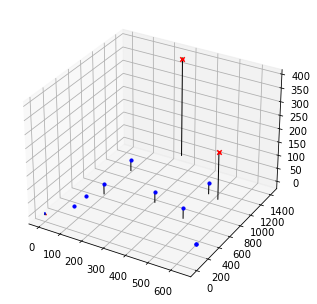

In [27]:
K1, R1 = projection_matrix.decompose_camera_matrix(P1)
center_1 = projection_matrix.calculate_camera_center(P1, K1, R1);
print(center_1)

K2, R2 = projection_matrix.decompose_camera_matrix(P2)
center_2 = projection_matrix.calculate_camera_center(P2, K2, R2);
print(center_2)

plot3dview_2_cameras(points_3d, center_1, center_2, R1.T, R2.T)

## Part 1.9 Questions:

1. What would happen to the projected points if you increased/decreased the x coordinate, or the other coordinates of the camera center t? Write down a description of your expectations in the appropriate part of your writeup submission.

2. Perform this shift for each of the camera coordinates and then recompose the projection matrix and visualize the result in your Jupyter notebook. You could use the image given as the part of the assignment for this analyses.

#### Answer

1. the projected points will go out of place if I increase or decrease the x coordinate of the camera center t. My expectation is that if I decrease the x coordinate, the projected points will shift to the left.
2. see code below, the first part is the image1 control. The second image is the shifted image

In [28]:
initial_guess_K = np.array([[   1,   0,  0],
                            [   0,   1,  0],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 1,   0, 0],
                              [ 0,   1, 0],
                              [ 0,   0, 1]])

initial_guess_I_t = np.array([[1, 0, 0, 320],
                              [0, 1, 0, 0],
                              [0, 0, 1, 500]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [29]:
# set the pats and load the data
pts2d_path = '../results/pts2d_image1.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([500., 375.])

`ftol` termination condition is satisfied.
Function evaluations 613, initial cost 1.8647e+06, final cost 4.4232e+03, first-order optimality 2.98e+01.
status True `ftol` termination condition is satisfied.
Time since optimization start 0.04627394676208496
The projection matrix is
 [[ 7.85101906e-01 -2.03270320e-01 -2.58620263e-02  9.18069275e+01]
 [ 6.22894754e-02  3.01934809e-01 -1.56739809e+00  1.55761948e+02]
 [ 5.63240259e-05 -6.16048897e-04 -3.64481342e-04  1.00000000e+00]]
The total residual is 179.308874


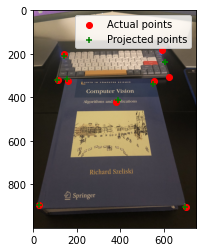

In [30]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

In [31]:
initial_guess_K = np.array([[   1,   0,  0],
                            [   0,   1,  0],
                            [   0,   0,  1]])

initial_guess_R_T = np.array([[ 1,   0, 0],
                              [ 0,   1, 0],
                              [ 0,   0, 1]])

initial_guess_I_t = np.array([[1, 0, 0, -1000],
                              [0, 1, 0, 0],
                              [0, 0, 1, 500]])

initial_guess_P = np.matmul(initial_guess_K, np.matmul(initial_guess_R_T, initial_guess_I_t))

In [32]:
# set the pats and load the data
pts2d_path = '../results/pts2d_image1.npy'
pts3d_path = '../results/pts3d_fiducial.npy'

points_2d = np.loadtxt(pts2d_path)
points_3d = np.loadtxt(pts3d_path)
img = load_image(image1_path)
np.array(img.shape[:2])/2

array([500., 375.])

`ftol` termination condition is satisfied.
Function evaluations 600, initial cost 2.0014e+06, final cost 5.8379e+04, first-order optimality 2.66e-05.
status True `ftol` termination condition is satisfied.
Time since optimization start 0.0463559627532959
The projection matrix is
 [[-1.19556769e+07  1.99318914e+07 -3.00001938e+08 -1.58859735e+08]
 [-2.69527734e+06  1.94015919e+07 -4.39198943e+08  2.46501869e+09]
 [-4.04725141e+03  8.39072940e+04 -1.45430641e+06  1.00000000e+00]]
The total residual is 851.100864


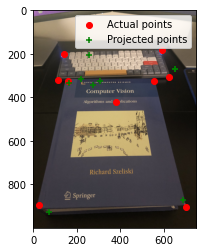

In [33]:
P = projection_matrix.estimate_camera_matrix(points_2d, points_3d, initial_guess_P)

print('The projection matrix is\n', P)

[projected_2d_pts, residual] = evaluate_points(P, points_2d, points_3d);

# residual is the sum of Euclidean distances between actual and projected points
print('The total residual is {:f}'.format(residual))
visualize_points_image(points_2d, projected_2d_pts, image1_path)

# Part 2 Fundamental Matrix Estimation

In this part you'll be estimating the fundamental matrix. You'll be using a least squares optimizer from SciPy. (Documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html)

The least squares optimizer takes an objective function, your variables to optimize, and the points that you want to fit a line to. In this case, the objective function is to minimize the point to line distance, where the line is the projection of a point onto another image by the fundamental matrix, and the point is an actual point of a feature in that image. The variable that you want to optimize would be the 9 values in the 3x3 Fundamental Matrix. The points that you are optimizing over are provided to you, and they are the homogeneous coordinates of corresponding features from two different images of the same scene.

## Part 2.1 Estimate Fundamental Matrix

Implement the `point_line_distance()` method in fundamental_matrix.py.

\begin{align}
    d(line, point) = \frac{au + bv + c}{\sqrt{a^2 + b^2}}
\end{align}

In [34]:
from unit_tests.test_fundamental_matrix import verify
from unit_tests.test_fundamental_matrix import TestFundamentalMatrix

test_fundamental_matrix_stereo = TestFundamentalMatrix()
TestFundamentalMatrix.setUp(test_fundamental_matrix_stereo)
print("test_point_line_distance(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance))
print("test_point_line_distance_zero(): " + verify(test_fundamental_matrix_stereo.test_point_line_distance_zero))

test_point_line_distance(): "Correct"
test_point_line_distance_zero(): "Correct"


Implement `signed_point_line_errors()`.

Keep in mind that SciPy does the squaring and summing for you, so all you have to do in `signed_point_line_errors()` is return a list of each individual error. So if there are 9 points, you have to calculate the `point_line_distance()` between each pair from $Fx_1$ to $x_0$ and also $F^Tx_0$ to $x_1$, then append all errors to a list, such that you end up returning a list of length 18. SciPy will take the list and square each element and sum everything for you. The red parts in the equation below are the parts you'll need to implement.

`signed_point_line_errors()`:
\begin{align}
    \color{red}{d(Fx_1, x_0)}^2 + \color{red}{d(F^T x_0, x_1)}^2
\end{align}

You'll also have to make the call to SciPy's least squares optimizer in the `optimize()` method in least_squares_fundamental_matrix.py.

In [35]:
from unit_tests.test_fundamental_matrix import TestFundamentalMatrix2, TestFundamentalMatrix3

print("TestFundamentalMatrix():")
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_stereo.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_stereo.test_least_squares_optimize))

print("TestFundamentalMatrix2():")
test_fundamental_matrix_synthetic = TestFundamentalMatrix2()
TestFundamentalMatrix2.setUp(test_fundamental_matrix_synthetic)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_synthetic.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_synthetic.test_least_squares_optimize))

print("TestFundamentalMatrix3():")
test_fundamental_matrix_real = TestFundamentalMatrix3()
TestFundamentalMatrix3.setUp(test_fundamental_matrix_real)
print("test_signed_point_line_errors(): " + verify(test_fundamental_matrix_real.test_signed_point_line_errors))
print("test_least_squares_optimize(): " + verify(test_fundamental_matrix_real.test_least_squares_optimize))

TestFundamentalMatrix():
test_signed_point_line_errors(): "Correct"
`gtol` termination condition is satisfied.
Function evaluations 10, initial cost 0.0000e+00, final cost 0.0000e+00, first-order optimality 0.00e+00.
completed True `gtol` termination condition is satisfied.
test_least_squares_optimize(): "Correct"
TestFundamentalMatrix2():
test_signed_point_line_errors(): "Correct"
`xtol` termination condition is satisfied.
Function evaluations 11, initial cost 7.3298e-26, final cost 8.3202e-27, first-order optimality 1.14e-06.
completed True `xtol` termination condition is satisfied.
test_least_squares_optimize(): "Correct"
TestFundamentalMatrix3():
test_signed_point_line_errors(): "Correct"
`ftol` termination condition is satisfied.
Function evaluations 35, initial cost 3.9875e+00, final cost 3.9875e+00, first-order optimality 7.53e-01.
completed True `ftol` termination condition is satisfied.
test_least_squares_optimize(): "Correct"


Then run the following cell to find the Fundamental Matrix using least squares. You should see the epipolar lines in the correct places in the image.

`ftol` termination condition is satisfied.
Function evaluations 147, initial cost 2.3174e+04, final cost 9.5305e+00, first-order optimality 2.02e+00.
completed True `ftol` termination condition is satisfied.
[[-5.60826054e-05  5.93269138e-04 -1.46009979e-02]
 [ 8.72227413e-04 -1.54445028e-04 -2.39641427e+00]
 [-2.22600749e-01  1.74869963e+00  5.71294331e+01]]


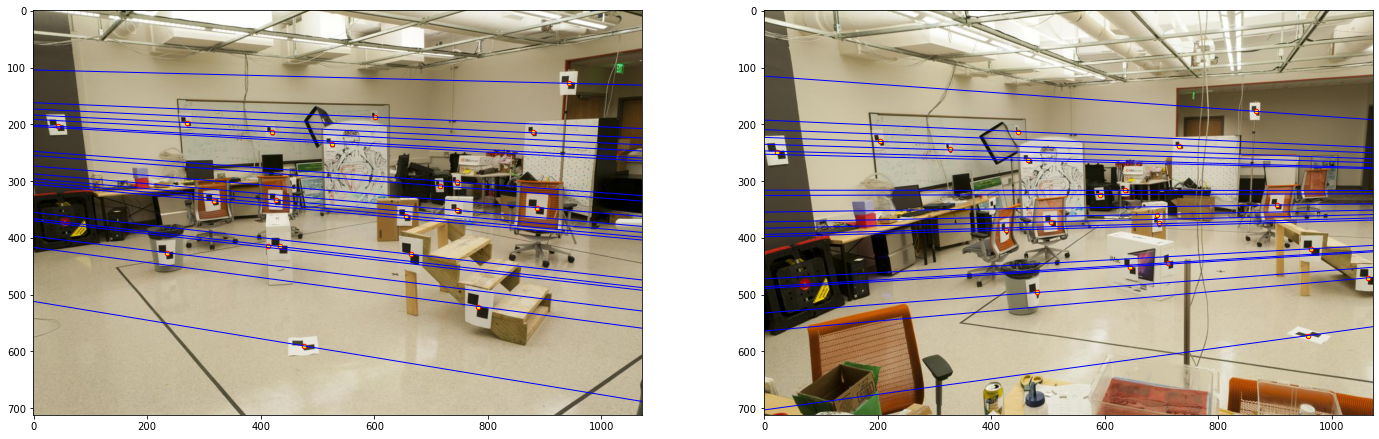

In [36]:
%matplotlib inline
# Load the data for room images
points_2d_pic_a = np.loadtxt('../data/pts2d-pic_a.txt')
points_2d_pic_b = np.loadtxt('../data/pts2d-pic_b.txt')
img_left = load_image('../data/pic_a.jpg')
img_right = load_image('../data/pic_b.jpg')

import least_squares_fundamental_matrix as ls

F = ls.solve_F(points_2d_pic_a, points_2d_pic_b)
print(F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(F, img_left, img_right, points_2d_pic_a, points_2d_pic_b)

## Part 2.2 Try Fundamental Matrix Estimation Yourself

Now you're going to take two images yourself and estimate the fundamental matrix between them. To do this, take two images and save them as "my_image_0.jpg" and "my_image_1.jpg" in the "/data" folder.

In [37]:
# Load the data for room images
my_img_left = load_image('../data/book1.jpg')
my_img_right = load_image('../data/book2.jpg')

To collect your own data points, run the following cell and mouse over features in the image and record the x- and y-coordinates. You'll need at least 9 points because we are trying to optimize for 9 variables, one for each element in the 3x3 fundamental matrix. Think about how you can choose good features for estimating the fundamental matrix.

**Store your points in variable "my_image_0_pts" and "my_image_1_pts" respectively.**

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


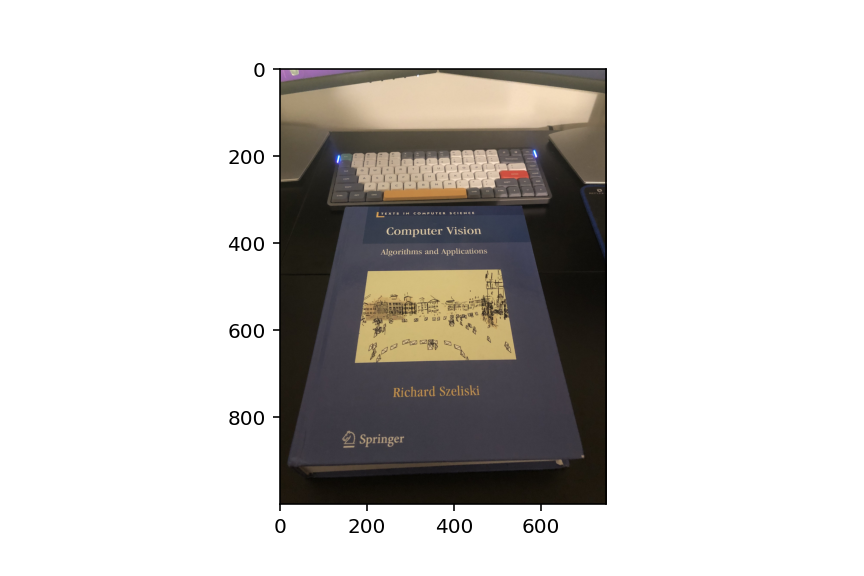

In [45]:
%matplotlib
# plotting image 1
image_0 = plt.figure(); image_0_ax = image_0.add_subplot(111); image_0_ax.imshow(my_img_left)

In [39]:
#my_image_0_pts = np.array([[0, 0]]) # Record your coordinates here
my_image_0_pts = np.array([[24,  893], [157, 323], [553, 323], [700, 903], 
                          [111, 319], [139, 199], [590, 181], [622, 305], 
                          [378, 420]])

<IPython.core.display.Javascript object>


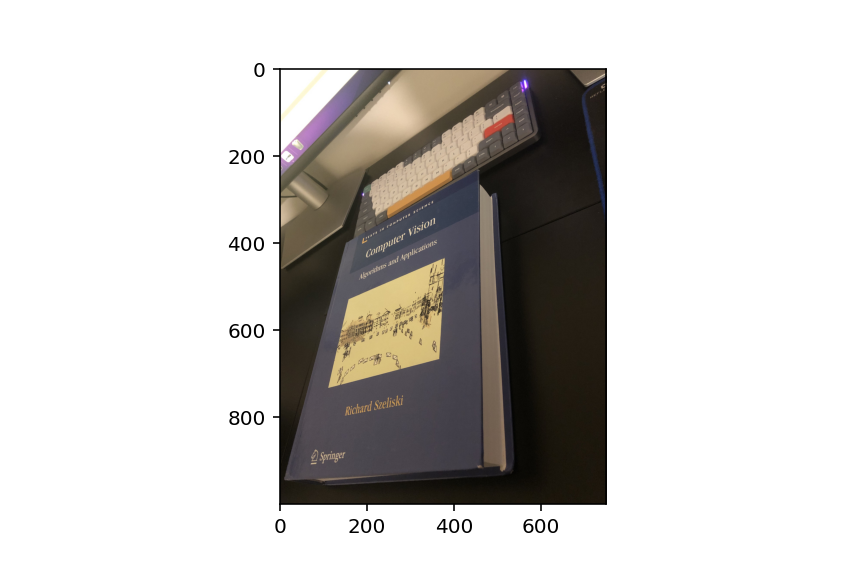

In [46]:
# plotting image 2
image_1 = plt.figure(); image_1_ax = image_1.add_subplot(111); image_1_ax.imshow(my_img_right)

In [41]:
#my_image_1_pts = np.array([[0, 0]]) # Record your coordinates here
my_image_1_pts = np.array([[15, 949], [157, 406], [456, 241], [470, 922], 
                          [171, 383], [190, 273], [571, 25], [590, 158],
                          [281, 434]])

`ftol` termination condition is satisfied.
Function evaluations 291, initial cost 7.2823e+04, final cost 2.9216e+01, first-order optimality 2.93e+06.
completed True `ftol` termination condition is satisfied.
[[ 6.61139045e-05  8.13219807e-05 -3.76239930e-02]
 [-9.61822378e-05 -2.17695060e-05  6.54732059e-02]
 [-2.13500633e-02 -5.25308601e-02  1.04212551e+01]]


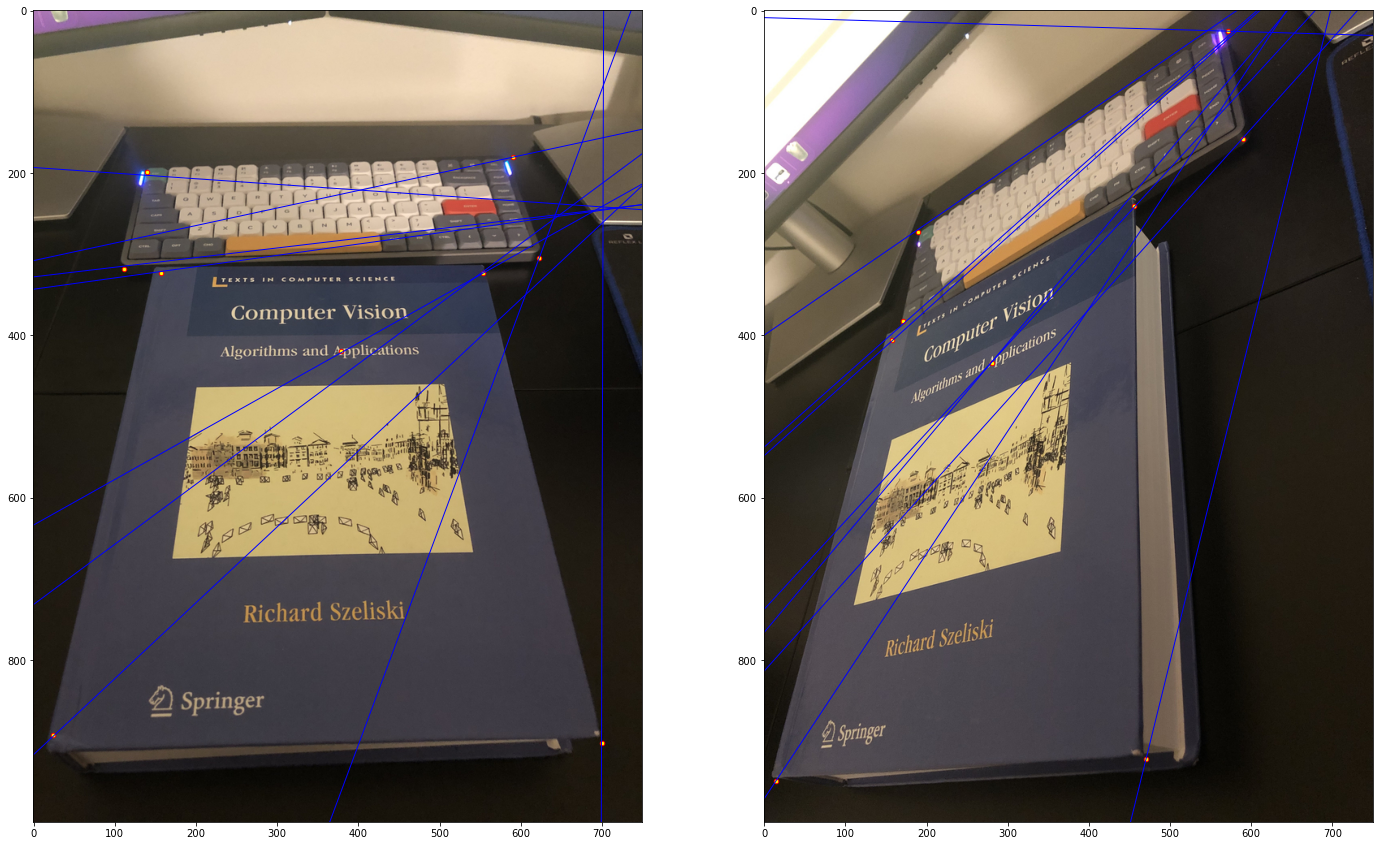

In [42]:
%matplotlib inline
import two_view_data as two_view_data
my_F = ls.solve_F(my_image_0_pts, my_image_1_pts)
print(my_F)

# Draw epipolar lines using the fundamental matrix
draw_epipolar_lines(my_F, my_img_left, my_img_right, my_image_0_pts, my_image_1_pts)

## Part 2.3 Questions

1. Why is it that when you take your own images, you can’t just rotate the camera or zoom the image for your two images of the same scene?
2. Why is it that points in one image are projected by the fundamental matrix onto epipolar lines in the other image?
3. What happens to the epipoles and epipolar lines when you take two images where the camera centers are within the images? Why?
4. What does it mean when your epipolar lines are all horizontal across the two images?
5. Why is the fundamental matrix defined up to a scale?
6. Why is the fundamental matrix rank 2?

#### Answer 1
because the fundamental matrix is assumed to be the same for both scenes. Different camera pose and type will ensure that the fundamental matrix to be different. 

#### Answer 2
That point lies along an epipolar line in image1, so it can be projected to the epipolar line that the same point in the other image lies.

#### Answer 3
Camera center within the image would only mean that two cameras are essentially looking in the same direction. This means that the epipole is at the vertically at the point of infinity and the epipolar lines are parallel with each other

#### Answer 4

Two cameras have been horizontally aligned with each other

#### Answer 5

the fundamental matrix represents the projective transformation between the two camera views

#### Answer 6

the fundamental matrix represents the relationship between two images in a epipolar plane

## Part 3: Fundamental Matrix with RANSAC (Szeliski 6.1.4)

Now we will automate the process of finding the fundamental matrix for an image by using SIFTNet to identify interest points and using RANSAC to robustly find true interest point matches between the two images. We will give you a correct implementation of SIFTNet.

We will implement a workflow using the SIFTNet from project 2
to extract feature points, then RANSAC will select a random subset of those points, 
you will call your function from part 2 to calculate the fundamental matrix for those points, 
and then you will check how many other points identified by SIFTNet match this
fundamental matrix. Then you will repeat this process and select another subset of points using RANSAC until you find the subset of points that produces the best fundamental matrix with the most
matching points. Refer to the lecture slides for the RANSAC workflow.

You can also find a simple explanation of RANSAC at 
https://www.mathworks.com/discovery/ransac.html.
See section 6.1.4 in the textbook for a more thorough explanation of how RANSAC works.

## RANSAC Iterations
Begin by calculating the number of iterations $S$ RANSAC will need to perform to guarentee a given success rate $P$ knowing the number of points included in the sample $k$ and the probability of an individual point being a true match $p$. To derive this formula, consider the following:
 * the probability that any one point has a true match is $p$
  * conversely the probability that any one point is not a match is $1-p$
  * the probability that two points are both matches is then $p \cdot p$
  * this can be extendeed to $k$ points, for which the probability that they are all true matches is $p^k$
 * on the other hand, we want the probability that $k$ points are all true matches to be $P$ (and the probability that they are not to be $1-P$)
 * by repeatedly sampling $k$ points, we can reduce the probability that all of the samples do not contain $k$ true matches
 * After $S$ samples we want the probability of failure to equal $1-P$
 
Start by setting up this equality $$1-P = ...$$
and then rearange it to write a function to solve for $S$

In [43]:
from ransac import calculate_num_ransac_iterations
from unit_tests.test_ransac import test_calculate_num_ransac_iterations

P = 0.999
k = 9
p = 0.9
# call their ransac iterations function
S = calculate_num_ransac_iterations(P, k, p)
# print number of trials they will need to run
print('S =', int(S))

print("Test for calculate_num_ransac_iterations(): " + verify(test_calculate_num_ransac_iterations))

AttributeError: module 'torch.jit' has no attribute '_script_if_tracing'

## Questions


1. How many RANSAC iterations would we need to find the fundamental matrix with 99.9% certainty from your Mount Rushmore SIFTNet results assuming that they had a 90% point correspondence accuracy?

2. One might imagine that if we had more than 9 point correspondences, it would be better to use more of them to solve for the fundamental matrix. Investigate this by finding the number of RANSAC iterations you would need to run with 18 points.

3. If our dataset had a lower point correspondence accuracy, say 70%, what is the minimum number of iterations needed to find the fundamental matrix with 99.9% certainty?

4. At the end of this assignment you will be performing RANSAC to find the fundamental matrix for an image pair that you create, and you will want to keep the estimated accuracy of your point correspondences in mind when deciding how many iterations are appropriate.

#### Answer 1


#### Answer 2


#### Answer 3



## RANSAC Implementation
Next we will implement the RANSAC algorithm. Remember the steps from the link above:
 1. Randomly selecting a subset of the data set
 1. Fitting a model to the selected subset
 1. Determining the number of outliers
 1. Repeating steps 1-3 for a prescribed number of iterations

For the application of finding true point pair matches and using them to calculate the fundamental matrix, our subset of the data will be the minimum number of point pairs needed to calculate the fundamental matrix.
The model we are fitting is the fundamental matrix.
Outliers will be found by using the `point_line_distance()` error function from part 2 and thresholding with a certain margin of error.

In [ ]:
from ransac import ransac_fundamental_matrix
from unit_tests import test_ransac

points_a = np.load('unit_tests/pointsa.npy')
points_b = points_a

F, _, _ = ransac_fundamental_matrix(points_a, points_b)
print('F= ', F)

print("Test for ransac_find_inliers(): " + verify(test_ransac.test_ransac_find_inliers))
print("Test for ransac_fundamental_matrix(), F matches inliers: " + verify(test_ransac.test_ransac_fundamental_matrix_error))
print("Test for ransac_fundamental_matrix(), F matches all points: " + verify(test_ransac.test_ransac_fundamental_matrix_fit))

## Finally we will put it all together.

The code below will call SIFTNet, determine the number RANSAC iterations using your function, and run your RANSAC calculating the fundamental matrix with your function at each pass. You shouldn't have to implement any new functions for this.

In [ ]:
from feature_matching.SIFTNet import get_siftnet_features
from feature_matching.utils import load_image, PIL_resize, rgb2gray
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Rushmore
image1 = load_image('../data/2a_rushmore.jpg')
image2 = load_image('../data/2b_rushmore.jpg')

scale_factor = 0.5
image1 = PIL_resize(image1, (int(image1.shape[1]*scale_factor), int(image1.shape[0]*scale_factor)))
image2 = PIL_resize(image2, (int(image2.shape[1]*scale_factor), int(image2.shape[0]*scale_factor)))
image1_bw = rgb2gray(image1)
image2_bw = rgb2gray(image2)

#convert images to tensor
tensor_type = torch.FloatTensor
torch.set_default_tensor_type(tensor_type)
to_tensor = transforms.ToTensor()
image_input1 = to_tensor(image1_bw).unsqueeze(0)
image_input2 = to_tensor(image2_bw).unsqueeze(0)

from feature_matching.HarrisNet import get_interest_points
from feature_matching.utils import show_interest_points
x1, y1, _ = get_interest_points(image_input1.float())
x2, y2, _ = get_interest_points(image_input2.float())

x1, x2 = x1.detach().numpy(), x2.detach().numpy()
y1, y2 = y1.detach().numpy(), y2.detach().numpy()
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))
image1_features = get_siftnet_features(image_input1, x1, y1)
image2_features = get_siftnet_features(image_input2, x2, y2)

from feature_matching.student_feature_matching import match_features
matches, confidences = match_features(image1_features, image2_features, x1, y1, x2, y2)
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))

from feature_matching.utils import show_correspondence_circles, show_correspondence_lines
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.title('Proposed Matches'); plt.imshow(c2)

from ransac import ransac_fundamental_matrix
# print(image1_features.shape, image2_features.shape)
num_features = min([len(image1_features), len(image2_features)])
x0s = np.zeros((len(matches), 2))
x1s = np.zeros((len(matches), 2))
x0s[:,0] = x1[matches[:, 0]]
x0s[:,1] = y1[matches[:, 0]]
x1s[:,0] = x2[matches[:, 1]]
x1s[:,1] = y2[matches[:, 1]]
# print(image1_pts.shape)
F, matches_x0, matches_x1 = ransac_fundamental_matrix(x0s, x1s)
print(F)
# print(matches_x0)
# print(matches_x1)

from utils import draw_epipolar_lines
# Draw the epipolar lines on the images and corresponding matches
match_image = show_correspondence_lines(image1, image2,
                                   matches_x0[:num_pts_to_visualize, 0], matches_x0[:num_pts_to_visualize, 1],
                                   matches_x1[:num_pts_to_visualize, 0], matches_x1[:num_pts_to_visualize, 1])
plt.figure(); plt.title('True Matches'); plt.imshow(match_image)
draw_epipolar_lines(F, image1, image2, matches_x0, matches_x1)

We can visualize the fundamental matrix by drawing the epipolar lines as shown above. As we learned these lines are the projections of the points in one image onto the other image. The point where they intersect is where the other picture was taken. 

## Create your own unit test
To verify all of your own work, **create** your *own* unit test which will plot the epipolar lines on two images that *you* will take and verify that your algorithms found a valid fundamental matrix by confirming that the epipolar lines intersect where the second image was taken (this should be *clearly visible* in the image frame - see the example). 

To get this to work well, you will need to consider what properties are necessary in two images for both SIFT features and for the fundamental matrix to work well. For example, are our methods robust against all possible transformations, occlusion, and image features.

Hint: use the code in the previous cell and input your own images.

In [ ]:
# draw epipolar lines and visualize on images with second camera in image
from ransac import test_with_epipolar_lines

test_with_epipolar_lines()